In [3]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Data Cleaning

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
COLOR_WORDS = {
    'red', 'green', 'blue', 'yellow', 'black', 'white', 'pink', 'orange', 'purple', 'brown',
    'grey', 'gray', 'ivory', 'beige', 'silver', 'gold', 'multi', 'navy', 'lime', 'turquoise'
}

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_description(desc):
    # Convert description to lowercase
    desc = desc.lower()

    # Remove numbers
    desc = re.sub(r'\d+', '', desc)

    # Remove punctuation/special characters
    desc = re.sub(r'[^\w\s]', '', desc)

    words = desc.split()

    # Remove color words
    words = [word for word in words if word not in COLOR_WORDS]

    # Remove stopwords
    words = [word for word in words if word not in STOPWORDS]

    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [6]:
df = pd.read_json("online_retail.json")
descriptions = set(df['FuzzedDescription'])

In [7]:
cleaned_descriptions = []

for description in descriptions:
    cleaned = clean_description(description)
    cleaned_descriptions.append(cleaned)

In [8]:
description_df = pd.DataFrame({
    'Description': list(descriptions),
    "Cleaned": cleaned_descriptions
})

# Clustering

In [9]:
import google.generativeai as genai
import json

In [10]:
with open('secrets.json') as f:
    secrets = json.load(f)

In [11]:
api_key = secrets['GEMINI_API_KEY']
genai.configure(api_key=api_key)

In [12]:
embeddings = [
    genai.embed_content(
        model="models/embedding-001",
        content=desc,
        task_type="semantic_similarity"
    )['embedding']
    for desc in description_df["Cleaned"]
]

In [13]:
description_df['Embedding'] = embeddings

In [14]:
description_df.to_csv("descriptions.csv", index=False)


In [15]:
df = pd.read_json("online_retail.json")
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate units sold by product and date
daily_sales = df.groupby(['Date', 'FuzzedDescription'])['UnitsSold'].sum().unstack(fill_value=0)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
reduced = pca.fit_transform(embeddings)

In [17]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_reduced = reducer.fit_transform(embeddings)

c:\Users\brian\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# K-Means

In [18]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [20]:
# Full embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(embeddings)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(embeddings, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.0485
k=3, silhouette score=0.0473
k=4, silhouette score=0.0473
k=5, silhouette score=0.0625
k=6, silhouette score=0.0550
k=7, silhouette score=0.0584
k=8, silhouette score=0.0703
k=9, silhouette score=0.0596
k=10, silhouette score=0.0767
k=11, silhouette score=0.0746
k=12, silhouette score=0.0775
k=13, silhouette score=0.0881
k=14, silhouette score=0.0669
k=15, silhouette score=0.0640
k=16, silhouette score=0.0921
k=17, silhouette score=0.0908
k=18, silhouette score=0.0929
k=19, silhouette score=0.0987
k=20, silhouette score=0.0727
k=21, silhouette score=0.0900
k=22, silhouette score=0.0803
k=23, silhouette score=0.0767
k=24, silhouette score=0.0972
k=25, silhouette score=0.0996
k=26, silhouette score=0.0947
k=27, silhouette score=0.1027
k=28, silhouette score=0.0897
k=29, silhouette score=0.1030
k=30, silhouette score=0.0923


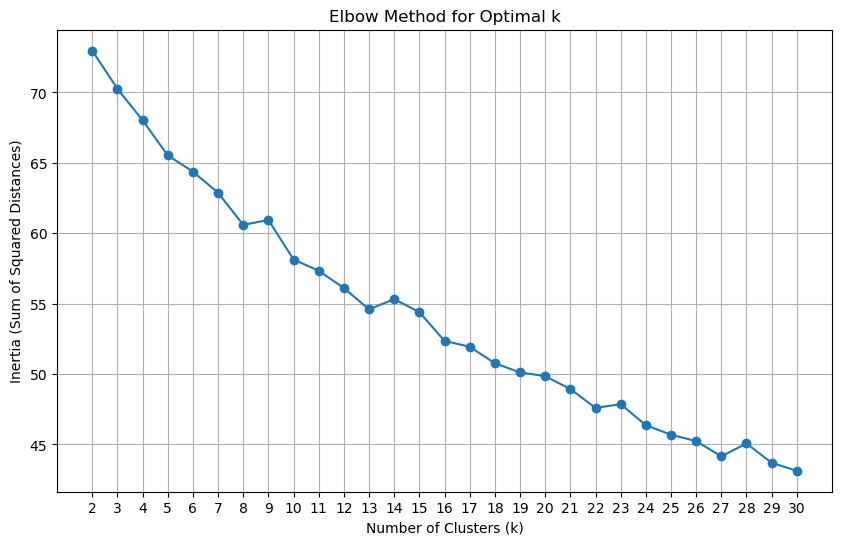

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [24]:
# PCA Reduced Embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(reduced)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(reduced, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.1525
k=3, silhouette score=0.1328
k=4, silhouette score=0.1529
k=5, silhouette score=0.1546
k=6, silhouette score=0.1859
k=7, silhouette score=0.1992
k=8, silhouette score=0.2036
k=9, silhouette score=0.2551
k=10, silhouette score=0.2611
k=11, silhouette score=0.2198
k=12, silhouette score=0.2656
k=13, silhouette score=0.2630
k=14, silhouette score=0.2533
k=15, silhouette score=0.2590
k=16, silhouette score=0.2484
k=17, silhouette score=0.2466
k=18, silhouette score=0.2416
k=19, silhouette score=0.2555
k=20, silhouette score=0.2329
k=21, silhouette score=0.2382
k=22, silhouette score=0.2542
k=23, silhouette score=0.2505
k=24, silhouette score=0.2437
k=25, silhouette score=0.2319
k=26, silhouette score=0.2594
k=27, silhouette score=0.2594
k=28, silhouette score=0.2655
k=29, silhouette score=0.2407
k=30, silhouette score=0.2556


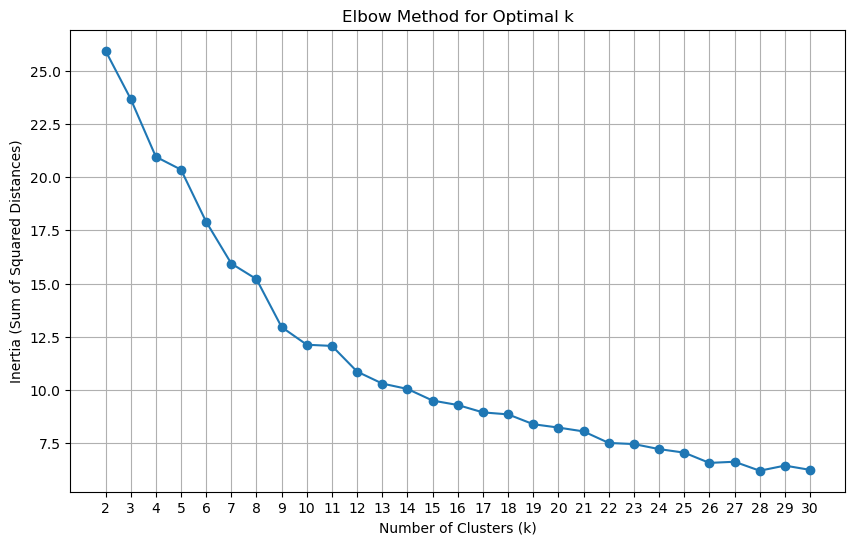

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [26]:
# UMAP Reduced Embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(umap_reduced)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(umap_reduced, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.4012
k=3, silhouette score=0.3750
k=4, silhouette score=0.4420
k=5, silhouette score=0.4886
k=6, silhouette score=0.4760
k=7, silhouette score=0.4593
k=8, silhouette score=0.4731
k=9, silhouette score=0.4793
k=10, silhouette score=0.5208
k=11, silhouette score=0.5401
k=12, silhouette score=0.5432
k=13, silhouette score=0.5324
k=14, silhouette score=0.5466
k=15, silhouette score=0.5147
k=16, silhouette score=0.5326
k=17, silhouette score=0.5248
k=18, silhouette score=0.5326
k=19, silhouette score=0.5381
k=20, silhouette score=0.5194
k=21, silhouette score=0.5402
k=22, silhouette score=0.5196
k=23, silhouette score=0.5238
k=24, silhouette score=0.5276
k=25, silhouette score=0.4888
k=26, silhouette score=0.5004
k=27, silhouette score=0.5213
k=28, silhouette score=0.5336
k=29, silhouette score=0.5053
k=30, silhouette score=0.4495


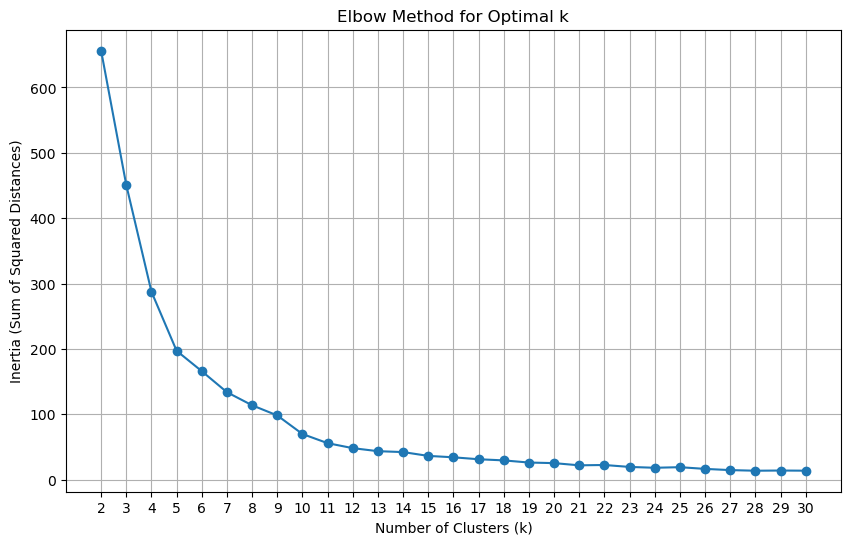

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [28]:
kmeans = KMeans(n_clusters=13)
labels = kmeans.fit_predict(umap_reduced)

In [29]:
description_df['K-Means_Cluster'] = labels

In [30]:
df = df.merge(
    description_df[['Description', 'K-Means_Cluster']],
    left_on='FuzzedDescription',
    right_on='Description',
    how='left'
).drop(columns=['Description'], errors='ignore')

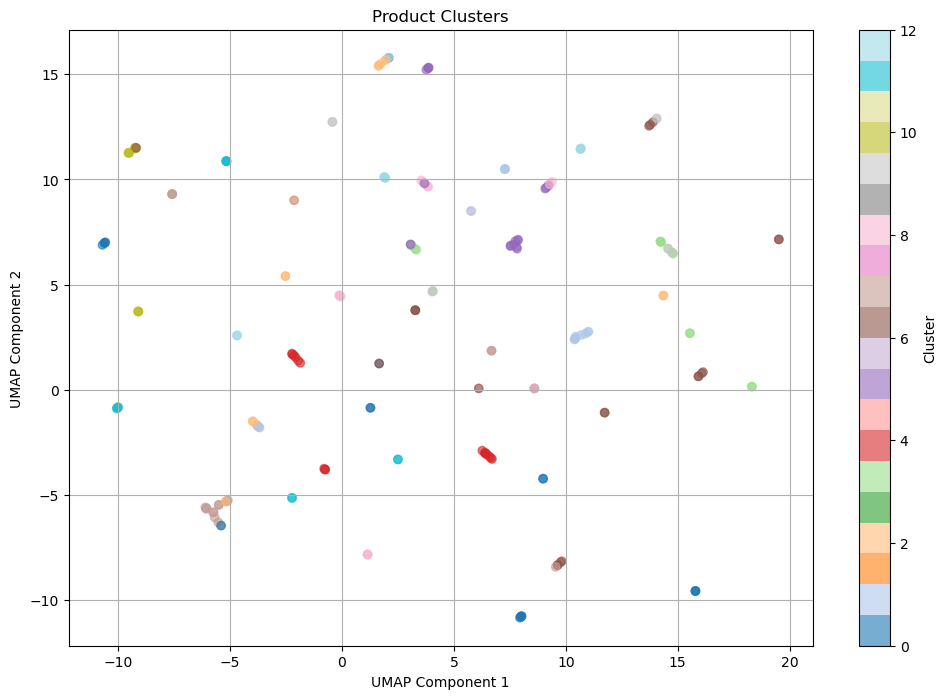

In [31]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['K-Means_Cluster'], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

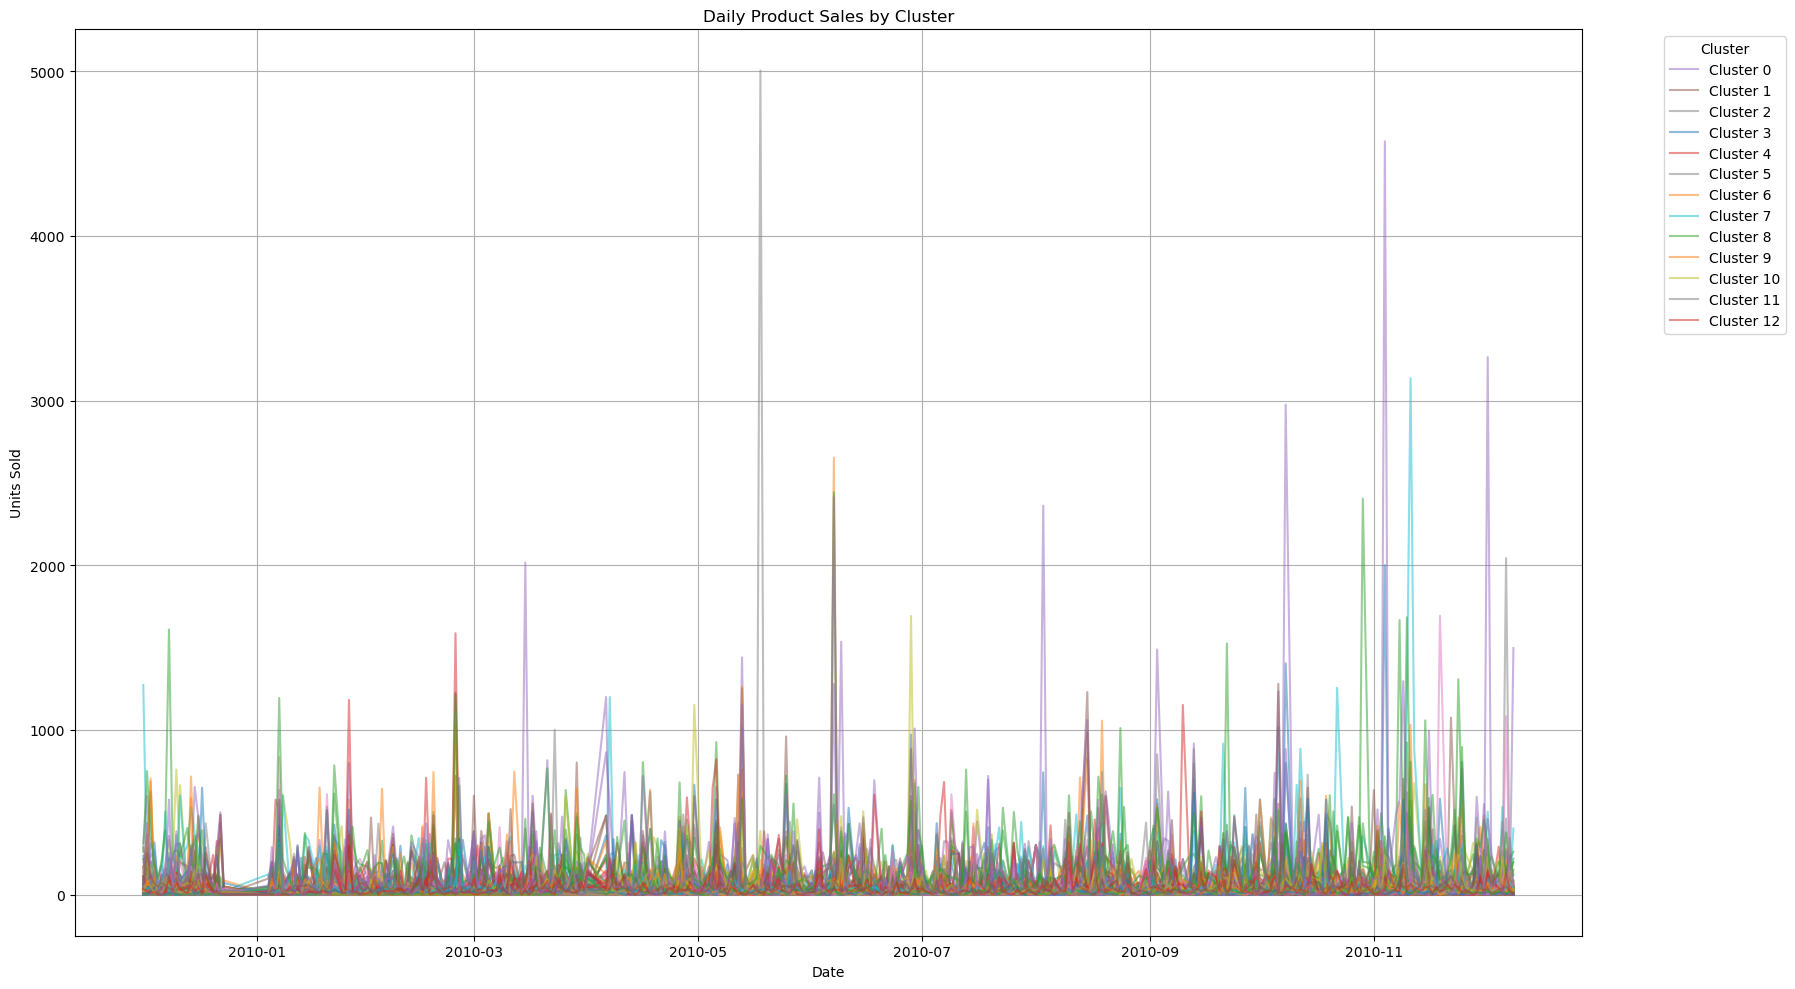

In [32]:
clustered_products = set(df['FuzzedDescription'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['FuzzedDescription'] == desc, 'K-Means_Cluster'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Map products to clusters
# product_cluster_map = pd.Series(description_df['K-Means_Cluster'])

# for cluster_id in sorted(description_df['K-Means_Cluster'].unique()):
#     # Filter data for current cluster
#     cluster_df = df[df['K-Means_Cluster'] == cluster_id]

#     # Group by Description and Date, summing UnitsSold
#     grouped = cluster_df.groupby(['Description', 'Date'])['UnitsSold'].sum().unstack(fill_value=0)

#     # Plot each product's time series
#     plt.figure(figsize=(14, 6))
#     for product in grouped.index:
#         plt.plot(grouped.columns, grouped.loc[product], label=product, alpha=0.7)

#     plt.title(f"Cluster {cluster_id} - Daily Sales by Product")
#     plt.xlabel("Date")
#     plt.ylabel("Units Sold")
#     plt.legend(loc='upper right', fontsize='small', title='Product')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [34]:
clusters = df.groupby('K-Means_Cluster')['FuzzedDescription'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- 6 ribbons rustic charm
- antique silver tea glass etched
- blue happy birthday bunting
- memo board cottage design
- natural slate rectangle chalkboard
- paper bunting retro spots
- paper chain kit retro spot
- party bunting
- ribbon reel spots design
- set 12 retro white chalk sticks
- white wood garden plant ladder
- wood 2 drawer cabinet white finish
- wood black board ant white finish
- wood s3 cabinet ant white finish
- wooden box of dominoes
- wooden frame antique white
- wooden happy birthday garland
- wooden picture frame white finish
- wooden school colouring set

Cluster 1:
- 60 teatime fairy cake cases
- 72 sweetheart fairy cake cases
- fairy cake notebook a5 size
- pack of 12 hearts design tissues
- pack of 6 birdy gift tags
- pack of 6 pannetone gift boxes
- pack of 60 dinosaur cake cases
- pack of 60 mushroom cake cases
- pack of 60 pink paisley cake cases
- pack of 60 spaceboy cake cases
- pack of 72 retro spot cake cases
- pack of 72 skull cake cases
- pink

# DBSCAN
(Density-Based Spatial Clustering of Applications with Noise)

In [35]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

In [36]:
def tune_dbscan(embeddings, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_labels = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(embeddings)

            # Skip if all points are labeled as noise or just one cluster
            if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
                continue

            score = silhouette_score(embeddings, labels)
            print(f"eps={eps}, min_samples={min_samples}, silhouette_score={score:.4f}")

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_labels = labels

    if best_params is None:
        print("\n❌ No valid clusters found with current eps and min_samples ranges.")
        return None, None

    print(f"\nBest Params: eps={best_params[0]}, min_samples={best_params[1]}, silhouette_score={best_score:.4f}")
    return best_labels, best_params

In [37]:
eps_range = np.linspace(0.3, 10.0, 30)
min_samples_range = list(range(2, 15))

In [38]:
labels, best_params = tune_dbscan(embeddings, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=-0.0599
eps=0.6344827586206896, min_samples=2, silhouette_score=0.0336
eps=0.6344827586206896, min_samples=3, silhouette_score=0.0336
eps=0.6344827586206896, min_samples=4, silhouette_score=0.0179
eps=0.6344827586206896, min_samples=5, silhouette_score=0.0267
eps=0.6344827586206896, min_samples=6, silhouette_score=0.0172
eps=0.6344827586206896, min_samples=7, silhouette_score=0.0059
eps=0.6344827586206896, min_samples=8, silhouette_score=0.0093
eps=0.6344827586206896, min_samples=9, silhouette_score=0.0016
eps=0.6344827586206896, min_samples=10, silhouette_score=-0.0090
eps=0.6344827586206896, min_samples=11, silhouette_score=-0.0090

Best Params: eps=0.6344827586206896, min_samples=3, silhouette_score=0.0336


In [39]:
labels, best_params = tune_dbscan(reduced, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.0820
eps=0.3, min_samples=3, silhouette_score=0.0820
eps=0.3, min_samples=4, silhouette_score=0.0820
eps=0.3, min_samples=5, silhouette_score=0.0858
eps=0.3, min_samples=6, silhouette_score=0.0776
eps=0.3, min_samples=7, silhouette_score=0.0776
eps=0.3, min_samples=10, silhouette_score=0.0723
eps=0.3, min_samples=12, silhouette_score=0.0960
eps=0.3, min_samples=13, silhouette_score=0.1028
eps=0.3, min_samples=14, silhouette_score=0.1110

Best Params: eps=0.3, min_samples=14, silhouette_score=0.1110


In [40]:
labels, best_params = tune_dbscan(umap_reduced, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.4211
eps=0.3, min_samples=3, silhouette_score=0.4032
eps=0.3, min_samples=4, silhouette_score=0.3154
eps=0.3, min_samples=5, silhouette_score=0.2614
eps=0.3, min_samples=6, silhouette_score=0.1351
eps=0.3, min_samples=7, silhouette_score=0.0698
eps=0.3, min_samples=8, silhouette_score=-0.0019
eps=0.3, min_samples=9, silhouette_score=0.0749
eps=0.6344827586206896, min_samples=2, silhouette_score=0.1095
eps=0.6344827586206896, min_samples=3, silhouette_score=0.1095
eps=0.6344827586206896, min_samples=4, silhouette_score=-0.0273
eps=0.6344827586206896, min_samples=5, silhouette_score=0.2421
eps=0.6344827586206896, min_samples=6, silhouette_score=0.4366
eps=0.6344827586206896, min_samples=7, silhouette_score=0.4200
eps=0.6344827586206896, min_samples=8, silhouette_score=0.4247
eps=0.6344827586206896, min_samples=9, silhouette_score=0.3590
eps=0.6344827586206896, min_samples=10, silhouette_score=0.3160
eps=0.6344827586206896, min_samples=11, silhou

In [41]:
description_df['DBScan'] = labels

In [42]:
df = df.merge(
    description_df[['Description', 'DBScan']],
    left_on='FuzzedDescription',
    right_on='Description',
    how='left'
).drop(columns=['Description'], errors='ignore')

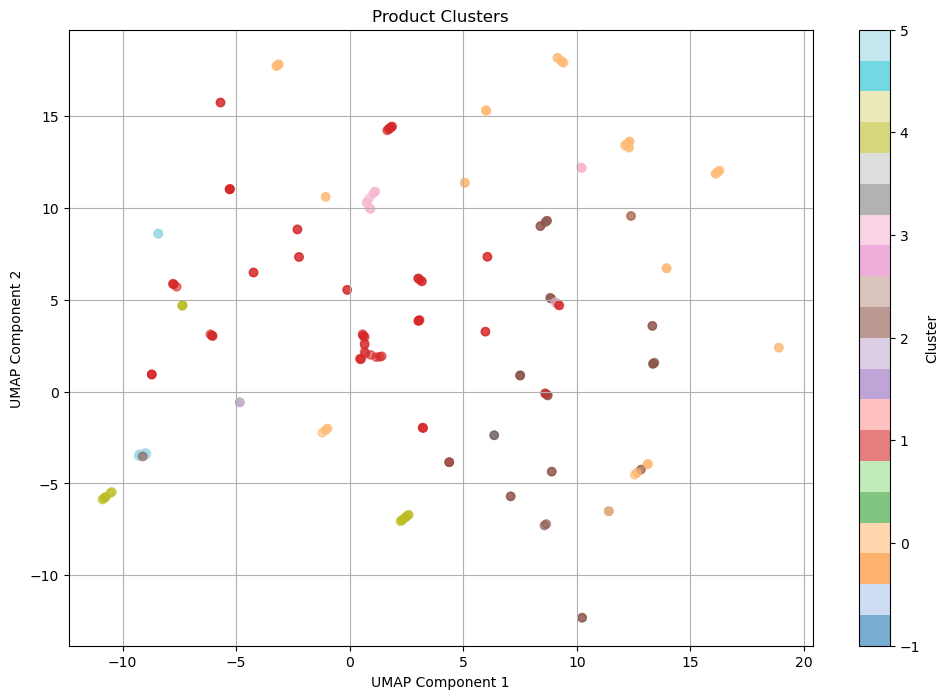

In [43]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['DBScan'], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

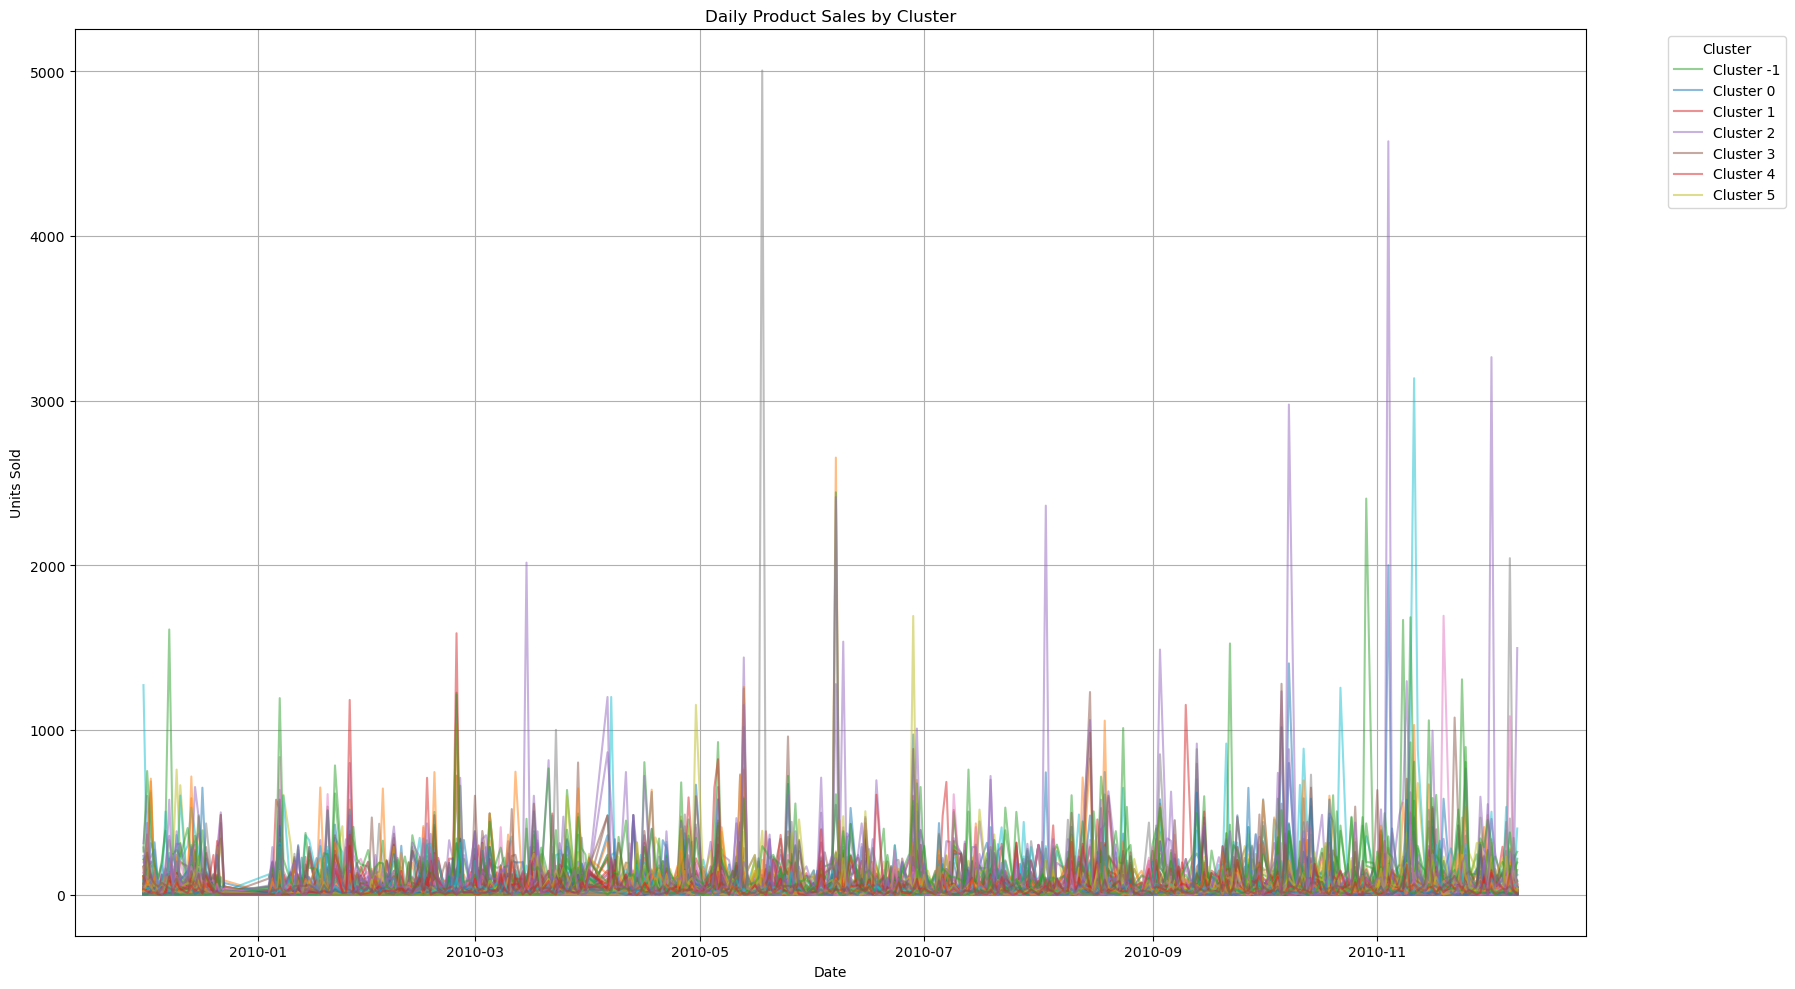

In [44]:
clustered_products = set(df['FuzzedDescription'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['FuzzedDescription'] == desc, 'DBScan'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
clusters = df.groupby('DBScan')['FuzzedDescription'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster -1:
- childs apron spaceboy design
- memo board cottage design

Cluster 0:
- 12 pencils small tube red spotty
- 12 pencils tall tube posy
- 12 pencils tall tube woodland
- airline bag vintage jet set red
- bag 500g swirly marbles
- baking set spaceboy design
- blue spotty cup
- charlotte bag pinkwhite spots
- charlotte bag suki design
- jumbo bag baroque black white
- jumbo bag pink vintage paisley
- jumbo bag pink with white spots
- jumbo bag scandinavian paisley
- jumbo bag spaceboy design
- jumbo bag strawberry
- jumbo bag toys
- jumbo shopper vintage red paisley
- jumbo storage bag skulls
- lunch bag black skull
- lunch bag cars blue
- lunch bag red spotty
- lunch bag woodland
- lunchbag spaceboy design
- lunchbag suki design
- magic drawing slate spaceboy
- plasters in tin circus parade
- plasters in tin skulls
- plasters in tin spaceboy
- plasters in tin strongman
- plasters in tin vintage paisley
- plasters in tin woodland animals
- red spotty biscuit tin
- red spotty bo

# HDBSCAN (Hierarchical DBSCAN)

In [46]:
import hdbscan

In [47]:
def tune_hdbscan(embeddings, min_cluster_sizes):
    best_score = -1
    best_params = None
    best_labels = None

    for size in min_cluster_sizes:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        labels = clusterer.fit_predict(embeddings)

        # Skip runs with only one cluster or all noise
        unique_labels = set(labels)
        if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
            continue

        score = silhouette_score(embeddings, labels)
        print(f"min_cluster_size={size}, silhouette_score={score:.4f}")

        if score > best_score:
            best_score = score
            best_params = size
            best_labels = labels

    if best_params is None:
        print("\n❌ No valid clustering found.")
        return None, None

    print(f"\n✅ Best min_cluster_size: {best_params} with silhouette_score={best_score:.4f}")
    return best_labels, best_params

In [48]:
min_cluster_sizes = range(2, 20)
labels, best_size = tune_hdbscan(embeddings, min_cluster_sizes)


min_cluster_size=2, silhouette_score=0.0392
min_cluster_size=3, silhouette_score=0.0290
min_cluster_size=4, silhouette_score=-0.0085
min_cluster_size=5, silhouette_score=-0.0197
min_cluster_size=6, silhouette_score=-0.0131
min_cluster_size=7, silhouette_score=-0.0176
min_cluster_size=8, silhouette_score=0.0077
min_cluster_size=9, silhouette_score=0.0104
min_cluster_size=10, silhouette_score=0.0115
min_cluster_size=11, silhouette_score=0.0088
min_cluster_size=12, silhouette_score=0.0047
min_cluster_size=13, silhouette_score=0.0090

✅ Best min_cluster_size: 2 with silhouette_score=0.0392


In [49]:
min_cluster_sizes = range(2, 20)
labels, best_size = tune_hdbscan(reduced, min_cluster_sizes)


min_cluster_size=2, silhouette_score=0.1642
min_cluster_size=3, silhouette_score=0.1065
min_cluster_size=4, silhouette_score=0.1305
min_cluster_size=5, silhouette_score=0.0661
min_cluster_size=6, silhouette_score=0.0256
min_cluster_size=7, silhouette_score=0.0295
min_cluster_size=8, silhouette_score=0.0369
min_cluster_size=9, silhouette_score=0.0311
min_cluster_size=10, silhouette_score=0.0165
min_cluster_size=11, silhouette_score=-0.0098
min_cluster_size=12, silhouette_score=-0.0191
min_cluster_size=13, silhouette_score=0.0158

✅ Best min_cluster_size: 2 with silhouette_score=0.1642


In [50]:
min_cluster_sizes = range(2, 20)
labels, best_size = tune_hdbscan(umap_reduced, min_cluster_sizes)


min_cluster_size=2, silhouette_score=0.3760
min_cluster_size=3, silhouette_score=0.4085
min_cluster_size=4, silhouette_score=0.4168
min_cluster_size=5, silhouette_score=0.3608
min_cluster_size=6, silhouette_score=0.3498
min_cluster_size=7, silhouette_score=0.3394
min_cluster_size=8, silhouette_score=0.3878
min_cluster_size=9, silhouette_score=0.1635
min_cluster_size=10, silhouette_score=0.1807
min_cluster_size=11, silhouette_score=0.1807
min_cluster_size=12, silhouette_score=0.1862
min_cluster_size=13, silhouette_score=0.1829
min_cluster_size=14, silhouette_score=0.1662
min_cluster_size=15, silhouette_score=0.1862
min_cluster_size=16, silhouette_score=0.1692
min_cluster_size=17, silhouette_score=0.0207
min_cluster_size=18, silhouette_score=0.0173
min_cluster_size=19, silhouette_score=-0.0304

✅ Best min_cluster_size: 4 with silhouette_score=0.4168


In [51]:
description_df['HDBScan'] = labels

In [52]:
df = df.merge(
    description_df[['Description', 'HDBScan']],
    left_on='FuzzedDescription',
    right_on='Description',
    how='left'
).drop(columns=['Description'], errors='ignore')

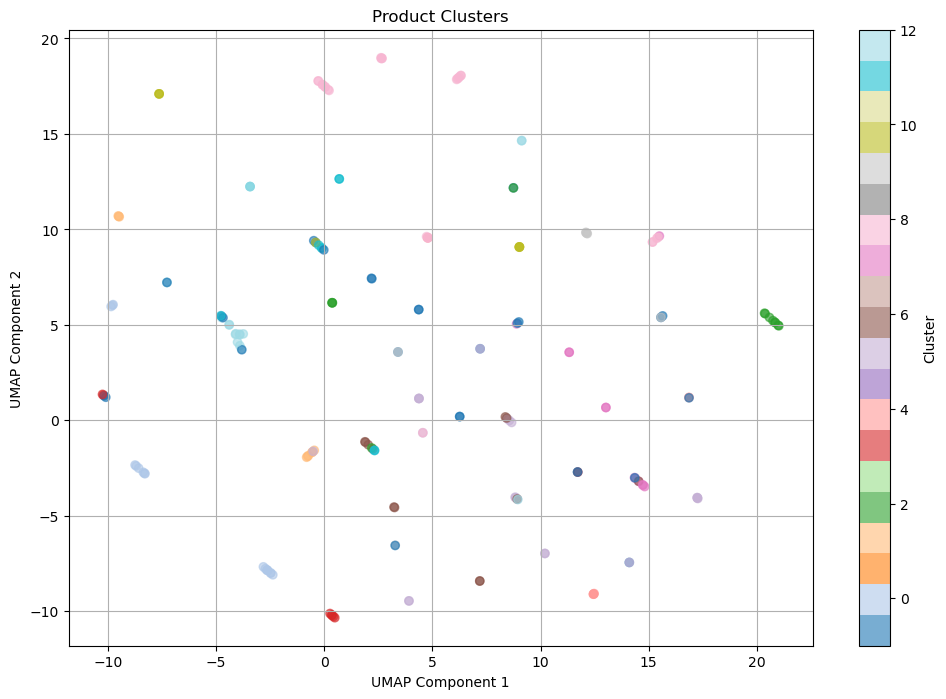

In [53]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['HDBScan'], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

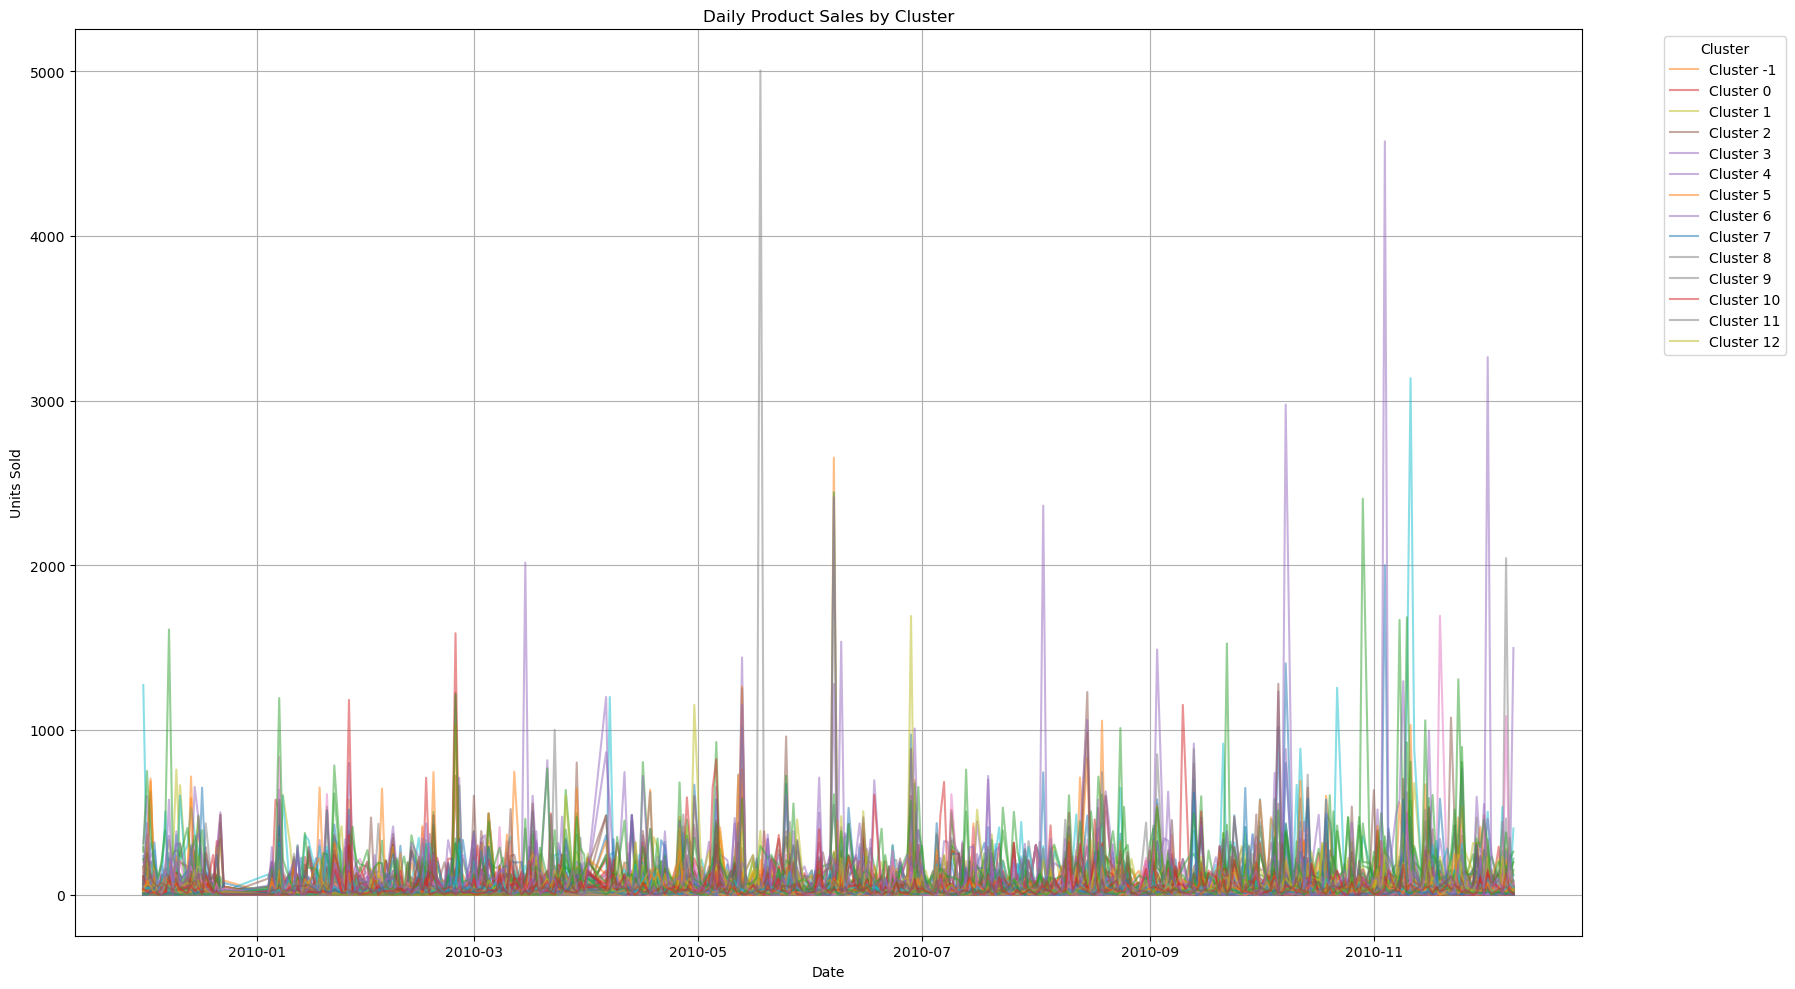

In [54]:
clustered_products = set(df['FuzzedDescription'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['FuzzedDescription'] == desc, 'HDBScan'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
clusters = df.groupby('HDBScan')['FuzzedDescription'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster -1:
- 12 pencils tall tube posy
- 12 pencils tall tube woodland
- antique silver tea glass etched
- assorted colour bird ornament
- baking set spaceboy design
- blue happy birthday bunting
- childs apron spaceboy design
- fancy font birthday card
- four hook white lovebirds
- heart filigree dove small
- hot water bottle tea and sympathy
- magic drawing slate spaceboy
- memo board cottage design
- natural slate rectangle chalkboard
- party bunting
- red gingham rose jewellery box
- red toadstool led night light
- round snack boxes set 4 fruits
- round snack boxes set4 woodland
- scottie dog hot water bottle
- set 12 retro white chalk sticks
- space boy birthday card
- strawberry ceramic trinket box
- tea time tea towels
- victorian sewing box large
- vintage snap cards
- vintage union jack bunting
- wooden box of dominoes

Cluster 0:
- bathroom metal sign
- beware of the cat metal sign
- chocolate this way metal sign
- cook with wine metal sign
- gin tonic diet metal sign
- gran

# Agglomerative (Hierarchical) Clustering

In [56]:
from sklearn.cluster import AgglomerativeClustering

In [57]:
def tune_agglomerative(embeddings, cluster_range, linkages, affinities):
    best_score = -1
    best_params = None
    best_labels = None

    for linkage in linkages:
        valid_affinities = ['euclidean'] if linkage == 'ward' else affinities

        for affinity in valid_affinities:
            for n_clusters in cluster_range:
                try:
                    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                    labels = model.fit_predict(embeddings)

                    print(f"Labels found: {set(labels)}, Count: {len(set(labels))}")

                    if len(set(labels)) <= 1:
                        continue

                    score = silhouette_score(embeddings, labels)
                    print(f"n_clusters={n_clusters}, linkage={linkage}, affinity={affinity}, silhouette_score={score:.4f}")

                    if score > best_score:
                        best_score = score
                        best_params = (n_clusters, linkage, affinity)
                        best_labels = labels
                except Exception as e:
                    print(f"⚠️ Skipping n_clusters={n_clusters}, linkage={linkage}, affinity={affinity} due to error: {e}")

    if best_params:
        print(f"\n✅ Best Params: n_clusters={best_params[0]}, linkage={best_params[1]}, affinity={best_params[2]}, silhouette_score={best_score:.4f}")
    else:
        print("\n❌ No valid clustering found.")
    
    return best_labels, best_params

In [58]:
cluster_range = range(2, 30)
linkages = ['ward', 'complete', 'average']
affinities = ['euclidean', 'manhattan', 'cosine']

#labels, best_params = tune_agglomerative(embeddings=embeddings, cluster_range=cluster_range, linkages=linkages, affinities=affinities)


In [59]:
#labels, best_params = tune_agglomerative(embeddings=reduced, cluster_range=cluster_range, linkages=linkages, affinities=affinities)

In [60]:
#labels, best_params = tune_agglomerative(embeddings=umap_reduced, cluster_range=cluster_range, linkages=linkages, affinities=affinities)


# Spectral Clustering

In [61]:
from sklearn.cluster import SpectralClustering

In [62]:
def tune_spectral_clustering(embeddings, cluster_range, affinities):
    best_score = -1
    best_params = None
    best_labels = None

    for affinity in affinities:
        for n_clusters in cluster_range:
            try:
                if affinity == 'nearest_neighbors':
                    model = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        n_neighbors=10,
                        assign_labels='kmeans',
                        random_state=42
                    )
                else:  # 'rbf'
                    model = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        assign_labels='kmeans',
                        random_state=42
                    )

                labels = model.fit_predict(embeddings)

                if len(set(labels)) <= 1:
                    continue  # Skip single-cluster results

                score = silhouette_score(embeddings, labels)
                print(f"n_clusters={n_clusters}, affinity={affinity}, silhouette_score={score:.4f}")

                if score > best_score:
                    best_score = score
                    best_params = (n_clusters, affinity)
                    best_labels = labels

            except Exception as e:
                print(f"⚠️ Skipping n_clusters={n_clusters}, affinity={affinity}: {e}")

    if best_params:
        print(f"\n✅ Best Params: n_clusters={best_params[0]}, affinity={best_params[1]}, silhouette_score={best_score:.4f}")
    else:
        print("\n❌ No valid clustering found.")

    return best_labels, best_params

In [63]:
cluster_range = range(2, 21)
affinities = ['rbf', 'nearest_neighbors']

best_labels, best_params = tune_spectral_clustering(embeddings, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.0475
n_clusters=3, affinity=rbf, silhouette_score=0.0501
n_clusters=4, affinity=rbf, silhouette_score=0.0558
n_clusters=5, affinity=rbf, silhouette_score=0.0608
n_clusters=6, affinity=rbf, silhouette_score=0.0649
n_clusters=7, affinity=rbf, silhouette_score=0.0680
n_clusters=8, affinity=rbf, silhouette_score=0.0754
n_clusters=9, affinity=rbf, silhouette_score=0.0776
n_clusters=10, affinity=rbf, silhouette_score=0.0854
n_clusters=11, affinity=rbf, silhouette_score=0.0908
n_clusters=12, affinity=rbf, silhouette_score=0.0906
n_clusters=13, affinity=rbf, silhouette_score=0.0926
n_clusters=14, affinity=rbf, silhouette_score=0.0938
n_clusters=15, affinity=rbf, silhouette_score=0.1003
n_clusters=16, affinity=rbf, silhouette_score=0.1040
n_clusters=17, affinity=rbf, silhouette_score=0.1028
n_clusters=18, affinity=rbf, silhouette_score=0.1017
n_clusters=19, affinity=rbf, silhouette_score=0.0993
n_clusters=20, affinity=rbf, silhouette_score=0.1092
n

In [64]:
best_labels, best_params = tune_spectral_clustering(reduced, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.1263
n_clusters=3, affinity=rbf, silhouette_score=0.1426


n_clusters=4, affinity=rbf, silhouette_score=0.1663
n_clusters=5, affinity=rbf, silhouette_score=0.1696
n_clusters=6, affinity=rbf, silhouette_score=0.1900
n_clusters=7, affinity=rbf, silhouette_score=0.2053
n_clusters=8, affinity=rbf, silhouette_score=0.2205
n_clusters=9, affinity=rbf, silhouette_score=0.2350
n_clusters=10, affinity=rbf, silhouette_score=0.2531
n_clusters=11, affinity=rbf, silhouette_score=0.2718
n_clusters=12, affinity=rbf, silhouette_score=0.2657
n_clusters=13, affinity=rbf, silhouette_score=0.2616
n_clusters=14, affinity=rbf, silhouette_score=0.2404
n_clusters=15, affinity=rbf, silhouette_score=0.2407
n_clusters=16, affinity=rbf, silhouette_score=0.2457
n_clusters=17, affinity=rbf, silhouette_score=0.2454
n_clusters=18, affinity=rbf, silhouette_score=0.2457
n_clusters=19, affinity=rbf, silhouette_score=0.2554
n_clusters=20, affinity=rbf, silhouette_score=0.2454
n_clusters=2, affinity=nearest_neighbors, silhouette_score=0.1521
n_clusters=3, affinity=nearest_neighbor

In [65]:
labels, best_params = tune_spectral_clustering(umap_reduced, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.3181
n_clusters=3, affinity=rbf, silhouette_score=0.3977
n_clusters=4, affinity=rbf, silhouette_score=0.3926
n_clusters=5, affinity=rbf, silhouette_score=0.4455
n_clusters=6, affinity=rbf, silhouette_score=0.4889
n_clusters=7, affinity=rbf, silhouette_score=0.4749
n_clusters=8, affinity=rbf, silhouette_score=0.4886
n_clusters=9, affinity=rbf, silhouette_score=0.4990
n_clusters=10, affinity=rbf, silhouette_score=0.4952
n_clusters=11, affinity=rbf, silhouette_score=0.5380
n_clusters=12, affinity=rbf, silhouette_score=0.5494
n_clusters=13, affinity=rbf, silhouette_score=0.5238
n_clusters=14, affinity=rbf, silhouette_score=0.5113
n_clusters=15, affinity=rbf, silhouette_score=0.5362
n_clusters=16, affinity=rbf, silhouette_score=0.5114
n_clusters=17, affinity=rbf, silhouette_score=0.5074
n_clusters=18, affinity=rbf, silhouette_score=0.5275
n_clusters=19, affinity=rbf, silhouette_score=0.5169
n_clusters=20, affinity=rbf, silhouette_score=0.5232
n

c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=4, affinity=nearest_neighbors, silhouette_score=0.4165
n_clusters=5, affinity=nearest_neighbors, silhouette_score=0.4786
n_clusters=6, affinity=nearest_neighbors, silhouette_score=0.4516


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=7, affinity=nearest_neighbors, silhouette_score=0.4817
n_clusters=8, affinity=nearest_neighbors, silhouette_score=0.4589
n_clusters=9, affinity=nearest_neighbors, silhouette_score=0.4626
n_clusters=10, affinity=nearest_neighbors, silhouette_score=0.4966


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=11, affinity=nearest_neighbors, silhouette_score=0.5199
n_clusters=12, affinity=nearest_neighbors, silhouette_score=0.5392
n_clusters=13, affinity=nearest_neighbors, silhouette_score=0.5278


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=14, affinity=nearest_neighbors, silhouette_score=0.5259
n_clusters=15, affinity=nearest_neighbors, silhouette_score=0.5397
n_clusters=16, affinity=nearest_neighbors, silhouette_score=0.5252


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=17, affinity=nearest_neighbors, silhouette_score=0.4536
n_clusters=18, affinity=nearest_neighbors, silhouette_score=0.5172


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=19, affinity=nearest_neighbors, silhouette_score=0.5170
n_clusters=20, affinity=nearest_neighbors, silhouette_score=0.4698

✅ Best Params: n_clusters=12, affinity=rbf, silhouette_score=0.5494


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [66]:
description_df['Spectral-Cluster'] = labels

In [67]:
df = df.merge(
    description_df[['Description', 'Spectral-Cluster']],
    left_on='FuzzedDescription',
    right_on='Description',
    how='left'
).drop(columns=['Description'], errors='ignore')

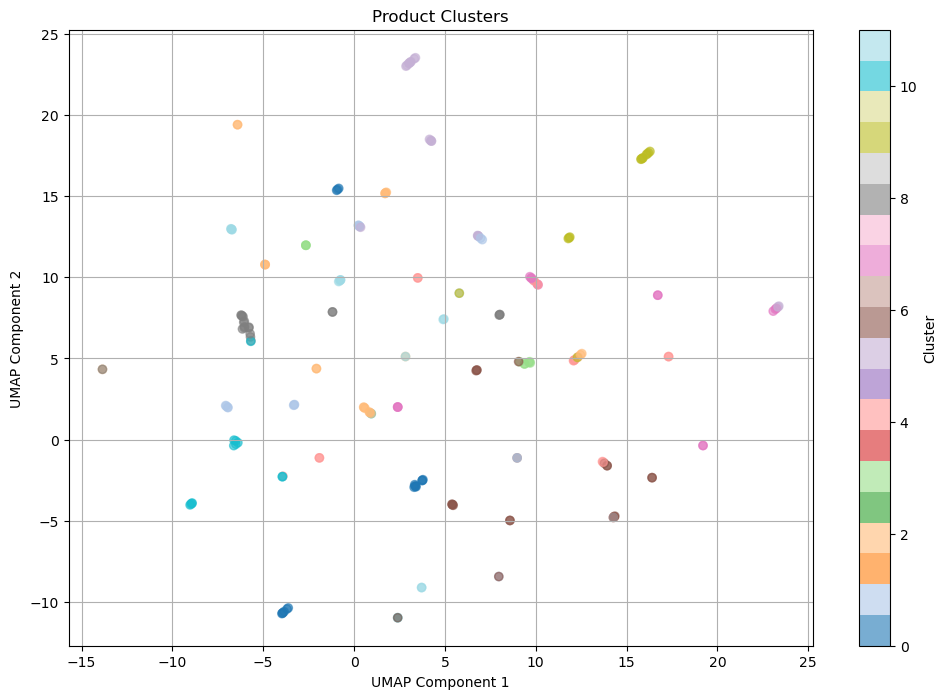

In [68]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['Spectral-Cluster'], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

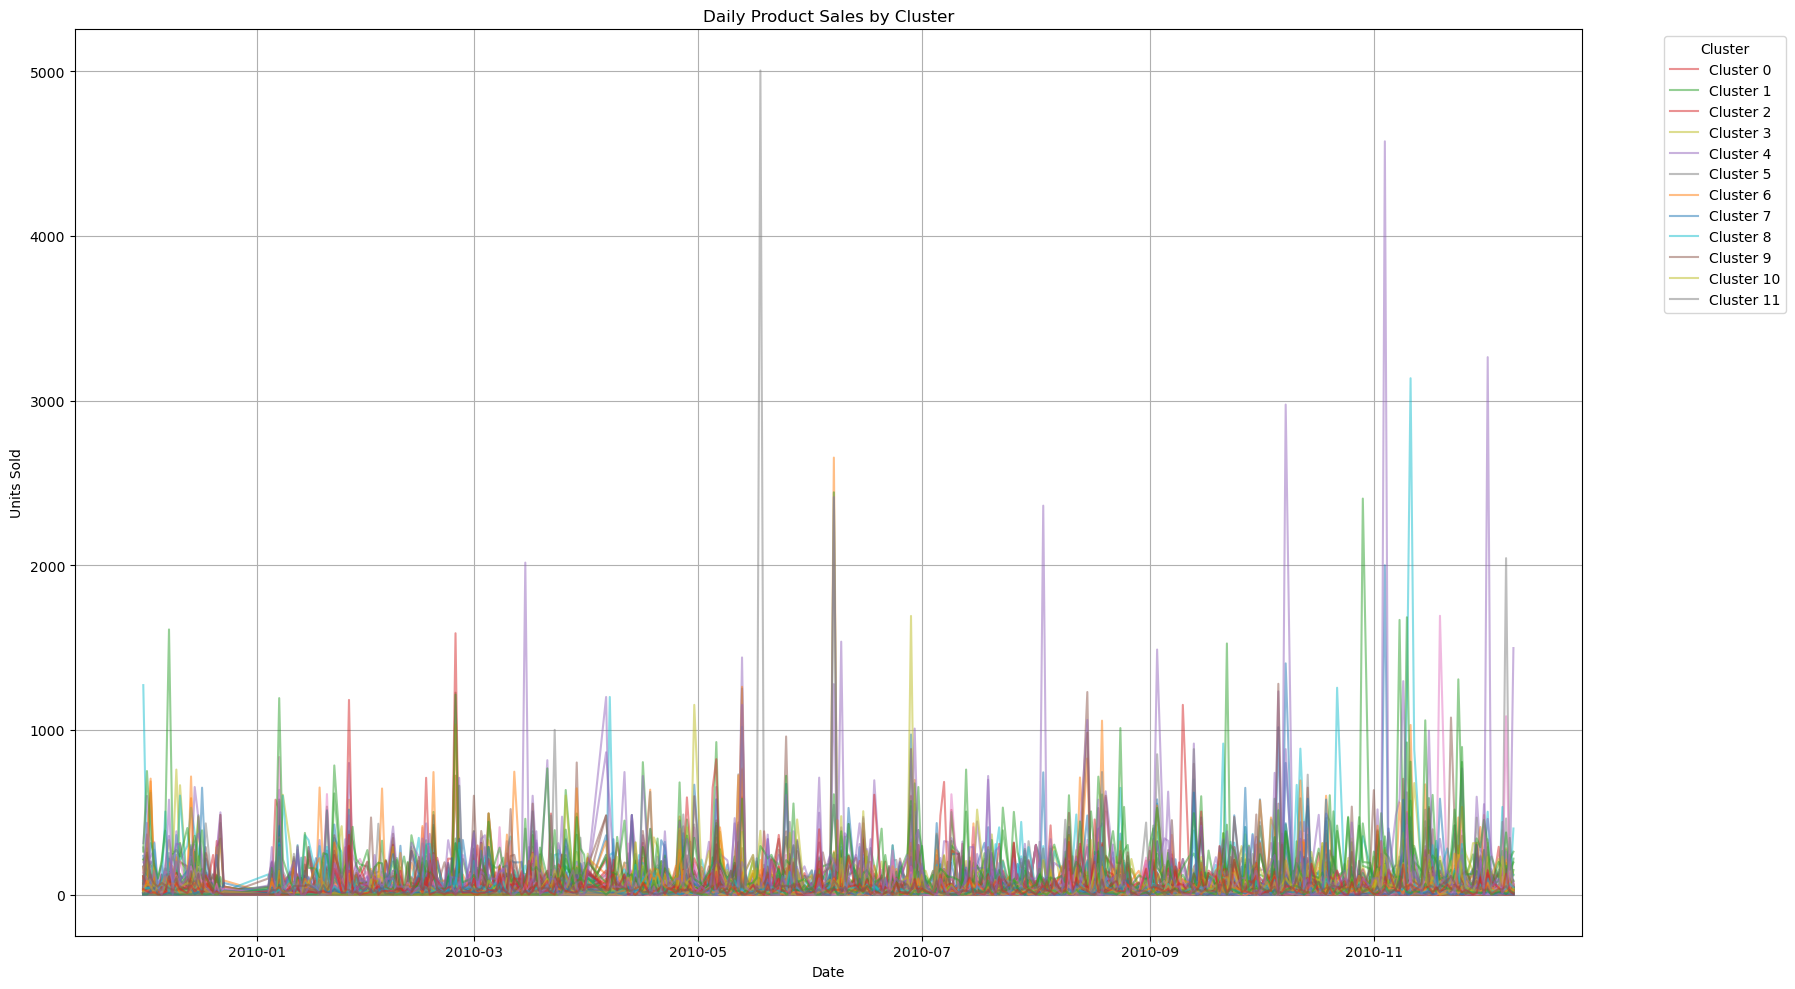

In [69]:
clustered_products = set(df['FuzzedDescription'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['FuzzedDescription'] == desc, 'Spectral-Cluster'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
clusters = df.groupby('Spectral-Cluster')['FuzzedDescription'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- bathroom metal sign
- beware of the cat metal sign
- chocolate this way metal sign
- cook with wine metal sign
- gin tonic diet metal sign
- grand chocolatecandle
- hand over the chocolate sign
- home sweet home metal sign
- hot baths metal sign
- im on holiday metal sign
- key fob shed
- ladies gentlemen metal sign
- metal sign take it or leave it
- no singing metal sign
- party metal sign
- pottering in the shed metal sign
- toilet metal sign

Cluster 1:
- baking set spaceboy design
- childs apron spaceboy design
- lunch bag black skull
- lunch bag cars blue
- lunch bag woodland
- lunchbag spaceboy design
- lunchbag suki design
- magic drawing slate spaceboy
- plasters in tin circus parade
- plasters in tin skulls
- plasters in tin spaceboy
- plasters in tin strongman
- plasters in tin vintage paisley
- plasters in tin woodland animals
- skull shoulder bag
- skulls water transfer tattoos
- toy tidy spaceboy

Cluster 2:
- 3 stripey mice feltcraft
- cream heart card holder

# Save clusters

In [71]:
df.to_csv("clustered_data.csv", index=False)

In [72]:
description_df.to_csv("description_clusters.csv", index=False)